In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image # Alias to avoid conflict
import numpy as np
import os
import random
import pathlib
import math

# --- 1. Parameters (Same as before + Seed) ---
DATA_DIR = '/kaggle/input/adavu-keyposture-20-classes/data_20_image'
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_CLASSES = 20 # Should match the number of folders found
VALIDATION_SPLIT = 0.2
SEED = 123 # Seed for reproducibility in sampling and splitting
AUTOTUNE = tf.data.AUTOTUNE # For prefetching optimization

print(f"Dataset Directory: {DATA_DIR}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Validation Split: {VALIDATION_SPLIT}")

# --- 2. Get All Image Paths and Class Names ---
data_dir_path = pathlib.Path(DATA_DIR)
image_paths = list(data_dir_path.glob('*/*.png')) + \
              list(data_dir_path.glob('*/*.jpg')) + \
              list(data_dir_path.glob('*/*.jpeg'))
image_paths = [str(p) for p in image_paths] # Convert paths to strings
random.seed(SEED)
random.shuffle(image_paths) # Shuffle all paths initially

class_names_found = sorted([item.name for item in data_dir_path.glob('*') if item.is_dir()])
if len(class_names_found) != NUM_CLASSES:
    print(f"⚠️ Warning: Found {len(class_names_found)} folders, but NUM_CLASSES is set to {NUM_CLASSES}. Using found folders.")
    NUM_CLASSES = len(class_names_found)

class_to_index = dict((name, index) for index, name in enumerate(class_names_found))
index_to_class = {v: k for k, v in class_to_index.items()} # For potential later use

print(f"Found {len(image_paths)} images belonging to {NUM_CLASSES} classes.")
print(f"Class names: {class_names_found}")

# --- 3. Group Paths by Class and Find Minimum Count ---
paths_by_class = {name: [] for name in class_names_found}
for path in image_paths:
    parent_dir_name = pathlib.Path(path).parent.name
    if parent_dir_name in paths_by_class:
        paths_by_class[parent_dir_name].append(path)

counts_per_class = {name: len(paths) for name, paths in paths_by_class.items()}
min_samples_per_class = min(counts_per_class.values())

print("\nImage counts per class (original):")
for name, count in counts_per_class.items():
    print(f"- {name}: {count}")
print(f"\nSmallest class has {min_samples_per_class} images. Undersampling others to match.")

# --- 4. Undersample File Paths ---
balanced_image_paths = []
balanced_labels = []

for class_name, paths in paths_by_class.items():
    # Randomly sample 'min_samples_per_class' from each list
    sampled_paths = random.sample(paths, min_samples_per_class)
    balanced_image_paths.extend(sampled_paths)
    # Get the corresponding integer label
    label_index = class_to_index[class_name]
    balanced_labels.extend([label_index] * min_samples_per_class)

# --- 5. Shuffle the Balanced Data Together ---
# Important: Shuffle paths and labels together to maintain correspondence
temp_list = list(zip(balanced_image_paths, balanced_labels))
random.shuffle(temp_list)
balanced_image_paths, balanced_labels = zip(*temp_list)
balanced_image_paths = list(balanced_image_paths)
balanced_labels = list(balanced_labels)

total_balanced_images = len(balanced_image_paths)
print(f"\nTotal images after balancing (undersampling): {total_balanced_images}")

# --- 6. Split Balanced Data into Train/Validation ---
val_size = math.floor(total_balanced_images * VALIDATION_SPLIT)
train_size = total_balanced_images - val_size

train_paths = balanced_image_paths[val_size:]
train_labels = balanced_labels[val_size:]
val_paths = balanced_image_paths[:val_size]
val_labels = balanced_labels[:val_size]

print(f"Splitting into {train_size} training samples and {val_size} validation samples.")

# --- 7. Create tf.data Datasets ---

def load_and_preprocess_image(path, label):
    """Loads image from path, decodes, resizes, and returns image tensor + label."""
    try:
        image_raw = tf.io.read_file(path)
        # Explicitly decode as JPEG, handle potential errors
        image = tf.io.decode_image(image_raw, channels=3, expand_animations=False) # Use decode_image
    except tf.errors.InvalidArgumentError:
        print(f"Warning: Skipping file {path}, could not decode.")
        return None, None # Indicate failure

    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    # No rescaling here (e.g., / 255.) because MobileNetV2 preprocessing does it.
    # If not using MobileNetV2 preprocessing later, add rescaling here.
    return image, label

def create_dataset(paths, labels):
    """Creates a tf.data.Dataset from file paths and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((path_ds, label_ds))

    # Use map with error handling (filtering out None results)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.filter(lambda image, label: image is not None) # Remove failed loads

    return dataset

# Create the datasets
train_dataset = create_dataset(train_paths, train_labels)
validation_dataset = create_dataset(val_paths, val_labels)

# --- 8. Configure Datasets for Performance ---
train_dataset = train_dataset.shuffle(buffer_size=train_size).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print("\n✅ Balanced Training and Validation Datasets created successfully!")
print(f"Training dataset element spec: {train_dataset.element_spec}")
print(f"Validation dataset element spec: {validation_dataset.element_spec}")

# You can now use train_dataset and validation_dataset in your model.fit() call

# --- Optional: Verify counts in the created datasets (takes time) ---
# print("\nVerifying dataset counts (this might take a moment)...")
# train_counts_final = {}
# for _, labels_batch in train_dataset.unbatch().batch(1024): # Process in larger chunks
#     unique, _, counts = tf.unique_with_counts(labels_batch)
#     for label, count in zip(unique.numpy(), counts.numpy()):
#         train_counts_final[label] = train_counts_final.get(label, 0) + count

# val_counts_final = {}
# for _, labels_batch in validation_dataset.unbatch().batch(1024):
#     unique, _, counts = tf.unique_with_counts(labels_batch)
#     for label, count in zip(unique.numpy(), counts.numpy()):
#         val_counts_final[label] = val_counts_final.get(label, 0) + count

# print("\nApproximate Training counts per class (from dataset):")
# for i in range(NUM_CLASSES):
#     print(f"- Class {i} ({index_to_class.get(i, 'N/A')}): {train_counts_final.get(i, 0)}")

# print("\nApproximate Validation counts per class (from dataset):")
# for i in range(NUM_CLASSES):
#     print(f"- Class {i} ({index_to_class.get(i, 'N/A')}): {val_counts_final.get(i, 0)}")

Dataset Directory: /kaggle/input/adavu-keyposture-20-classes/data_20_image
Image Size: (160, 160)
Batch Size: 32
Validation Split: 0.2
Found 24722 images belonging to 20 classes.
Class names: ['100', '103', '11', '153', '27', '3', '44', '45', '46', '47', '48', '49', '5', '59', '60', '77', '79', '8', '85', '87']

Image counts per class (original):
- 100: 806
- 103: 555
- 11: 2015
- 153: 6684
- 27: 1057
- 3: 5624
- 44: 240
- 45: 199
- 46: 548
- 47: 203
- 48: 410
- 49: 229
- 5: 939
- 59: 301
- 60: 382
- 77: 787
- 79: 767
- 8: 2036
- 85: 473
- 87: 467

Smallest class has 199 images. Undersampling others to match.

Total images after balancing (undersampling): 3980
Splitting into 3184 training samples and 796 validation samples.

✅ Balanced Training and Validation Datasets created successfully!
Training dataset element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset element spec: (TensorSpec(

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image # Alias if needed
import numpy as np
import os
import random
import pathlib
import math

# --- 1. Parameters ---
DATA_DIR = '/kaggle/input/adavu-keyposture-20-classes/data_20_image'
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_CLASSES = 20 # Initial assumption, will be verified
VALIDATION_SPLIT = 0.2
SEED = 123 # Seed for reproducibility
AUTOTUNE = tf.data.AUTOTUNE # For optimization

print(f"Dataset Directory: {DATA_DIR}")
print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Validation Split: {VALIDATION_SPLIT}")

# --- 2. Get All Image Paths and Class Names ---
data_dir_path = pathlib.Path(DATA_DIR)
# Find common image types
image_paths = list(data_dir_path.glob('*/*.[pP][nN][gG]')) + \
              list(data_dir_path.glob('*/*.[jJ][pP][gG]')) + \
              list(data_dir_path.glob('*/*.[jJ][pP][eE][gG]'))
image_paths = [str(p) for p in image_paths] # Convert paths to strings
random.seed(SEED)
random.shuffle(image_paths) # Shuffle all paths initially

class_names = sorted([item.name for item in data_dir_path.glob('*') if item.is_dir()])
if not class_names:
    raise ValueError(f"No subdirectories found in {DATA_DIR}. Check the path.")
if len(class_names) != NUM_CLASSES:
    print(f"⚠️ Warning: Found {len(class_names)} folders, but NUM_CLASSES was {NUM_CLASSES}. Updating NUM_CLASSES.")
    NUM_CLASSES = len(class_names)

class_to_index = dict((name, index) for index, name in enumerate(class_names))

print(f"\nFound {len(image_paths)} images belonging to {NUM_CLASSES} classes.")
print(f"Class names: {class_names}")

# --- 3. Group Paths by Class and Find Minimum Count ---
paths_by_class = {name: [] for name in class_names}
for path in image_paths:
    # Handle potential path separator issues
    parent_dir_name = os.path.basename(os.path.dirname(path))
    if parent_dir_name in paths_by_class:
        paths_by_class[parent_dir_name].append(path)
    else:
         print(f"Warning: Image '{path}' parent folder '{parent_dir_name}' not in expected class names. Skipping.")


counts_per_class = {name: len(paths) for name, paths in paths_by_class.items()}
# Check if any class has 0 images found
if any(count == 0 for count in counts_per_class.values()):
    print("\nImage counts per class (original):")
    for name, count in counts_per_class.items():
        print(f"- {name}: {count}")
    raise ValueError("One or more classes have zero images found. Cannot balance.")

min_samples_per_class = min(counts_per_class.values())

print("\nImage counts per class (original):")
for name, count in counts_per_class.items():
    print(f"- {name}: {count}")
print(f"\nSmallest class has {min_samples_per_class} images. Undersampling others to match.")

# --- 4. Undersample File Paths ---
balanced_image_paths = []
balanced_labels = []

random.seed(SEED) # Ensure sampling is reproducible
for class_name, paths in paths_by_class.items():
    if len(paths) >= min_samples_per_class:
        sampled_paths = random.sample(paths, min_samples_per_class)
        balanced_image_paths.extend(sampled_paths)
        label_index = class_to_index[class_name]
        balanced_labels.extend([label_index] * min_samples_per_class)
    else:
        # This case shouldn't happen due to the check above, but included for safety
        print(f"Warning: Class '{class_name}' had fewer images ({len(paths)}) than minimum ({min_samples_per_class}). Check data.")


# --- 5. Shuffle the Balanced Data Together ---
temp_list = list(zip(balanced_image_paths, balanced_labels))
random.seed(SEED) # Shuffle the combined list reproducibly
random.shuffle(temp_list)
balanced_image_paths, balanced_labels = zip(*temp_list)
balanced_image_paths = list(balanced_image_paths)
balanced_labels = list(balanced_labels)

total_balanced_images = len(balanced_image_paths)
print(f"\nTotal images after balancing (undersampling): {total_balanced_images}")
if total_balanced_images != NUM_CLASSES * min_samples_per_class:
     print(f"⚠️ Warning: Final balanced count ({total_balanced_images}) doesn't match expected ({NUM_CLASSES * min_samples_per_class}).")


# --- 6. Split Balanced Data into Train/Validation ---
val_size = math.floor(total_balanced_images * VALIDATION_SPLIT)
train_size = total_balanced_images - val_size

train_paths = balanced_image_paths[val_size:]
train_labels = balanced_labels[val_size:]
val_paths = balanced_image_paths[:val_size]
val_labels = balanced_labels[:val_size]

print(f"Splitting into {train_size} training samples and {val_size} validation samples.")

# --- 7. Create tf.data Datasets ---

def load_and_preprocess_image(path, label):
    """Loads image from path, decodes, resizes, and returns image tensor + label."""
    image = tf.io.read_file(path)
    # Use decode_image, handles PNG, JPG etc. more robustly
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    # Rescaling might be needed here if not using MobileNetV2 preprocess_input later
    # image = image / 255.0
    return image, label

# Error handling mapping function
def safe_load_and_preprocess(path, label):
    try:
        return load_and_preprocess_image(path, label)
    except Exception as e:
        # tf.print(f"Warning: Skipping file {path} due to error: {e}", output_stream=sys.stderr) # tf.print for graph mode
        # Return dummy data or filter later; here returning None to filter
        return (None, None)

def create_dataset(paths, labels, is_training=True):
    """Creates a tf.data.Dataset from file paths and labels."""
    if not paths or not labels:
        return tf.data.Dataset.from_tensor_slices(([], [])) # Return empty dataset if no paths/labels

    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((path_ds, label_ds))

    # Apply mapping with error catching and filter out failed items
    dataset = dataset.map(safe_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.filter(lambda image, label: image is not None)

    # Apply shuffling only to the training dataset
    if is_training:
         # Use dataset size for buffer or a large fixed number
         buffer_size = len(paths) # Or use a fixed large number like 1000
         dataset = dataset.shuffle(buffer_size=buffer_size, seed=SEED, reshuffle_each_iteration=True)

    # Apply batching and prefetching
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

# Create the final datasets
train_dataset = create_dataset(train_paths, train_labels, is_training=True)
validation_dataset = create_dataset(val_paths, val_labels, is_training=False) # No shuffle for validation


print("\n✅ Balanced Training and Validation tf.data.Datasets created successfully!")
print(f"Training dataset element spec: {train_dataset.element_spec}")
print(f"Validation dataset element spec: {validation_dataset.element_spec}")

# Now train_dataset and validation_dataset are ready for model.fit()
# The variable 'class_names' also holds the list of folder names found.

Dataset Directory: /kaggle/input/adavu-keyposture-20-classes/data_20_image
Image Size: (160, 160)
Batch Size: 32
Validation Split: 0.2

Found 24722 images belonging to 20 classes.
Class names: ['100', '103', '11', '153', '27', '3', '44', '45', '46', '47', '48', '49', '5', '59', '60', '77', '79', '8', '85', '87']

Image counts per class (original):
- 100: 806
- 103: 555
- 11: 2015
- 153: 6684
- 27: 1057
- 3: 5624
- 44: 240
- 45: 199
- 46: 548
- 47: 203
- 48: 410
- 49: 229
- 5: 939
- 59: 301
- 60: 382
- 77: 787
- 79: 767
- 8: 2036
- 85: 473
- 87: 467

Smallest class has 199 images. Undersampling others to match.

Total images after balancing (undersampling): 3980
Splitting into 3184 training samples and 796 validation samples.

✅ Balanced Training and Validation tf.data.Datasets created successfully!
Training dataset element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset element spec: (Te

In [18]:
print("Calculating class weights to handle imbalance...")

# Get all the labels from the training dataset
labels = []
for _, batch_labels in train_dataset:
    labels.extend(batch_labels.numpy())
labels = np.array(labels)

# Calculate the weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)

# Turn the weights into a dictionary Keras can use
class_weight_dict = dict(enumerate(class_weights))

print("Class weights calculated successfully.")
# print(class_weight_dict) # Uncomment this if you want to see the weights

Calculating class weights to handle imbalance...
Class weights calculated successfully.


In [19]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")

In [20]:
# 1. Load the base model (pre-trained on ImageNet)
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,  # Don't include its final 1000-class layer
    weights='imagenet'
)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create your new model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  # Apply augmentation first
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Pre-process for MobileNet
x = base_model(x, training=False)  # Run the frozen base model
x = layers.GlobalAveragePooling2D()(x) # Pool the features
x = layers.Dropout(0.2)(x)  # Add dropout for regularization
# Your final layer with 20 outputs (one for each folder)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x) 

model = Model(inputs, outputs)

In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Good for integer labels
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,283,604 (8.71 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
print("\nStarting model training...")

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    class_weight=class_weight_dict  # <-- This applies the balancing weights!
)

print("\n Training complete!")


Starting model training...
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8956 - loss: 0.3348 - val_accuracy: 0.8166 - val_loss: 0.4825
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9019 - loss: 0.3356 - val_accuracy: 0.8417 - val_loss: 0.4541
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9037 - loss: 0.3204 - val_accuracy: 0.8568 - val_loss: 0.4456
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9108 - loss: 0.2936 - val_accuracy: 0.8807 - val_loss: 0.3723
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9133 - loss: 0.2802 - val_accuracy: 0.8178 - val_loss: 0.4772
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9060 - loss: 0.2794 - val_accuracy: 0.8693 - val_loss: 0.3903
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9174 - loss: 0.2893 - val_accuracy: 0.8656 - val_loss: 0.3724
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.91

In [29]:
# Define paths in the writeable output directory
SAVE_PATH_MODEL = '/kaggle/working/my_balanced_classifier.h5'
SAVE_PATH_CLASSES = '/kaggle/working/class_names.json'

# Save the trained model
model.save(SAVE_PATH_MODEL)

# Save the class names
with open(SAVE_PATH_CLASSES, 'w') as f:
    json.dump(class_names, f)

print(f"Model saved to: {SAVE_PATH_MODEL}")
print(f"Class names saved to: {SAVE_PATH_CLASSES}")

Model saved to: /kaggle/working/my_balanced_classifier.h5
Class names saved to: /kaggle/working/class_names.json


Dataset Directory: /kaggle/input/adavu-keyposture-20-classes/data_20_image
Model Path: /kaggle/working/my_balanced_classifier.h5
Classes Path: /kaggle/working/class_names.json
✅ Class names loaded successfully.

🔄 Scanning image files...

Image counts per class (original):
- 100: 806
- 103: 555
- 11: 2015
- 153: 6684
- 27: 1057
- 3: 5624
- 44: 240
- 45: 199
- 46: 548
- 47: 203
- 48: 410
- 49: 229
- 5: 939
- 59: 301
- 60: 382
- 77: 787
- 79: 767
- 8: 2036
- 85: 473
- 87: 467

Smallest class has 199 images.
Selecting 39 validation samples per class.

Total validation images selected: 780

Creating validation dataset...
✅ Validation dataset created.
Validation dataset element spec: (TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

🏗️ Re-building model architecture & loading weights...
✅ Model re-built and weights loaded.

🧠 Generating predictions on the specific validation set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


✅ Confusion matrix plotted and saved as confusion_matrix_stratified_val.png.

📋 Classification Report:

              precision    recall  f1-score   support

         100       0.76      0.90      0.82        39
         103       1.00      0.92      0.96        39
          11       0.91      1.00      0.95        39
         153       1.00      1.00      1.00        39
          27       1.00      1.00      1.00        39
           3       0.93      0.97      0.95        39
          44       1.00      0.95      0.97        39
          45       0.95      0.97      0.96        39
          46       1.00      0.69      0.82        39
          47       0.80      0.95      0.87        39
          48       1.00      0.77      0.87        39
          49       0.80      1.00      0.89        39
           5       1.00      0.82      0.90        39
          59       0.91      1.00      0.95        39
          60       1.00      1.00      1.00        39
          77       1.00      0.

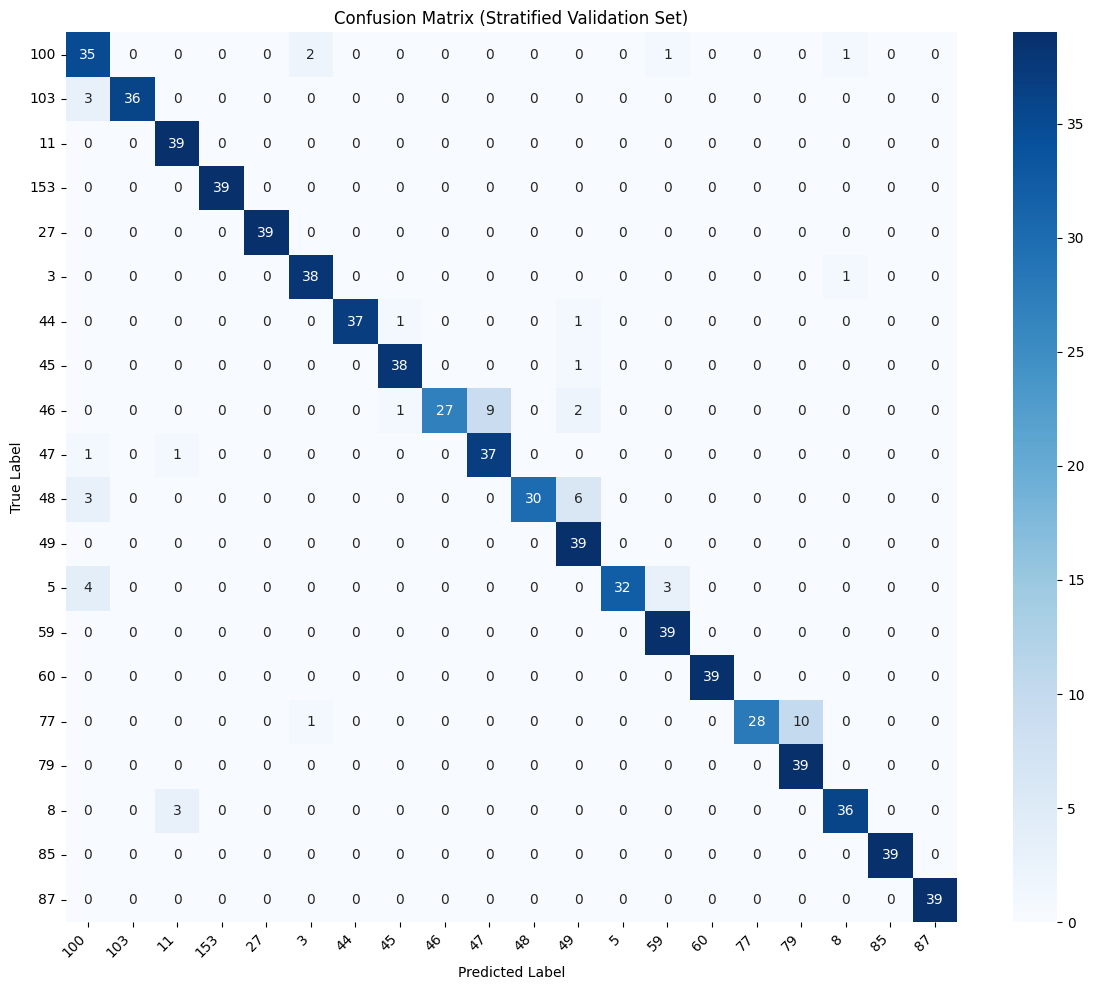

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image # Alias if needed
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
import numpy as np
import os
import random
import pathlib
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split # Import for stratified split
import sys

# --- 1. Parameters & Paths ---
DATA_DIR = '/kaggle/input/adavu-keyposture-20-classes/data_20_image'
MODEL_PATH = '/kaggle/working/my_balanced_classifier.h5'
CLASSES_PATH = '/kaggle/working/class_names.json'
IMG_SIZE = (160, 160)
BATCH_SIZE = 64 # Batch size for prediction
NUM_CLASSES = 20 # Initial assumption
VALIDATION_SPLIT = 0.2
SEED = 123 # Seed for reproducibility
AUTOTUNE = tf.data.AUTOTUNE

print(f"Dataset Directory: {DATA_DIR}")
print(f"Model Path: {MODEL_PATH}")
print(f"Classes Path: {CLASSES_PATH}")

# --- 2. Check File/Dir Existence ---
if not os.path.exists(MODEL_PATH): sys.exit(f"❌ Error: Model file not found at {MODEL_PATH}")
if not os.path.exists(DATA_DIR): sys.exit(f"❌ Error: Data directory not found at {DATA_DIR}")

# Load Class Names (with fallback and adjustment)
if os.path.exists(CLASSES_PATH):
    try:
        with open(CLASSES_PATH, 'r') as f: class_names = json.load(f)
        print("✅ Class names loaded successfully.")
    except Exception as e:
        print(f"⚠️ Error loading class names file: {e}. Using default names.")
        class_names = [str(i) for i in range(NUM_CLASSES)]
else:
    print(f"⚠️ Warning: Class names file not found. Using default numeric names.")
    class_names = [str(i) for i in range(NUM_CLASSES)]

# Verify NUM_CLASSES against actual folders found later if needed

# --- 3. Get All Image Paths and Group by Class ---
print("\n🔄 Scanning image files...")
data_dir_path = pathlib.Path(DATA_DIR)
image_paths = list(data_dir_path.glob('*/*.[pP][nN][gG]')) + \
              list(data_dir_path.glob('*/*.[jJ][pP][gG]')) + \
              list(data_dir_path.glob('*/*.[jJ][pP][eE][gG]'))
image_paths = [str(p) for p in image_paths]

found_class_names = sorted([item.name for item in data_dir_path.glob('*') if item.is_dir()])
if not found_class_names: sys.exit(f"❌ Error: No subdirectories found in {DATA_DIR}.")

if len(found_class_names) != NUM_CLASSES:
    print(f"⚠️ Warning: Found {len(found_class_names)} folders, using this count instead of initial NUM_CLASSES={NUM_CLASSES}.")
    NUM_CLASSES = len(found_class_names)
    # Re-adjust class_names list if needed
    if len(class_names) != NUM_CLASSES:
        print(f"⚠️ Adjusting class_names list length to {NUM_CLASSES}.")
        class_names = found_class_names # Use the found names directly

class_to_index = dict((name, index) for index, name in enumerate(class_names))
index_to_class = {v: k for k, v in class_to_index.items()}

paths_by_class = {name: [] for name in class_names}
for path in image_paths:
    parent_dir_name = os.path.basename(os.path.dirname(path))
    if parent_dir_name in paths_by_class:
        paths_by_class[parent_dir_name].append(path)

counts_per_class = {name: len(paths) for name, paths in paths_by_class.items()}
if any(count == 0 for count in counts_per_class.values()):
    print("\nImage counts per class (original):")
    for name, count in counts_per_class.items(): print(f"- {name}: {count}")
    sys.exit("❌ Error: One or more classes have zero images. Cannot proceed.")

min_samples_per_class = min(counts_per_class.values())

print("\nImage counts per class (original):")
for name, count in counts_per_class.items(): print(f"- {name}: {count}")
print(f"\nSmallest class has {min_samples_per_class} images.")

# --- 4. Select Stratified Validation Paths ---
val_paths = []
val_labels = []

random.seed(SEED) # Seed for sampling

# Calculate how many validation samples per class
val_samples_per_class = max(1, math.floor(min_samples_per_class * VALIDATION_SPLIT))
print(f"Selecting {val_samples_per_class} validation samples per class.")

for class_name, paths in paths_by_class.items():
    label_index = class_to_index[class_name]
    # Ensure we don't try to sample more than available, though min_samples logic should prevent this
    num_to_sample = min(val_samples_per_class, len(paths))
    if num_to_sample < val_samples_per_class:
         print(f"  ⚠️ Warning: Class '{class_name}' only has {num_to_sample} images, using all for validation.")

    # Randomly sample 'num_to_sample' paths JUST for validation
    sampled_val_paths = random.sample(paths, num_to_sample)
    val_paths.extend(sampled_val_paths)
    val_labels.extend([label_index] * num_to_sample)

total_val_images = len(val_paths)
print(f"\nTotal validation images selected: {total_val_images}")
if total_val_images != NUM_CLASSES * val_samples_per_class:
     print(f"⚠️ Warning: Final validation count ({total_val_images}) doesn't match expected ({NUM_CLASSES * val_samples_per_class}). Check class counts.")

# --- 5. Create Validation tf.data Dataset ---
print("\nCreating validation dataset...")

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    return image, label

def safe_load_and_preprocess(path, label):
    try: return load_and_preprocess_image(path, label)
    except Exception: return (None, None) # Filter out errors

def create_val_dataset(paths, labels):
    if not paths or not labels:
        return tf.data.Dataset.from_tensor_slices(([], [])).batch(BATCH_SIZE).prefetch(AUTOTUNE) # Handle empty

    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((path_ds, label_ds))
    dataset = dataset.map(safe_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.filter(lambda image, label: image is not None)
    dataset = dataset.batch(BATCH_SIZE) # Batch for prediction
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

validation_dataset_cm = create_val_dataset(val_paths, val_labels)
print("✅ Validation dataset created.")
print(f"Validation dataset element spec: {validation_dataset_cm.element_spec}")

# --- 6. Re-build Model Architecture & Load Weights ---
print("\n🏗️ Re-building model architecture & loading weights...")
try:
    data_augmentation = Sequential([
        layers.RandomFlip('horizontal'), layers.RandomRotation(0.2),
        layers.RandomZoom(0.1), layers.RandomContrast(0.2),
    ], name="data_augmentation")
    base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights=None)
    base_model.trainable = False
    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Keep if model was saved with it
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model_cm = Model(inputs, outputs)
    model_cm.load_weights(MODEL_PATH)
    print("✅ Model re-built and weights loaded.")
except Exception as e:
    sys.exit(f"❌ Error building model or loading weights: {e}")

# --- 7. Get Predictions and True Labels ---
print("\n🧠 Generating predictions on the specific validation set...")
try:
    y_pred_probs = model_cm.predict(validation_dataset_cm, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # True labels are directly from our val_labels list
    y_true = np.array(val_labels) # Convert list to numpy array for metrics functions

    # Quick verification of lengths
    if len(y_pred) != len(y_true):
         print(f"⚠️ Warning: Length mismatch! Predictions ({len(y_pred)}) vs True Labels ({len(y_true)}). This might happen if image loading failed.")
         # Attempt to get true labels directly from dataset again as a fallback
         y_true_ds = np.concatenate([y for x, y in validation_dataset_cm], axis=0)
         if len(y_pred) == len(y_true_ds):
             print("   Adjusting true labels based on successfully loaded images.")
             y_true = y_true_ds
         else:
             print("   Cannot resolve length mismatch. Metrics might be incorrect.")

    print(f"✅ Predictions ({len(y_pred)}) and true labels ({len(y_true)}) ready.")

except Exception as e:
    sys.exit(f"❌ Error during prediction or label extraction: {e}")


# --- 8. Count Validation Images Per Class (from the selected list) ---
print("\n🔢 Confirming selected validation images per class...")
try:
    unique_labels_selected, counts_selected = np.unique(y_true, return_counts=True)
    validation_counts_selected = dict(zip(unique_labels_selected, counts_selected))
    print("-----------------------------------------")
    print("Selected Validation Image Counts:")
    print("-----------------------------------------")
    total_val_images_check = 0
    for i, name in enumerate(class_names):
        count = validation_counts_selected.get(i, 0)
        print(f"Folder '{name}' (Index {i}): {count} images")
        total_val_images_check += count
    print("-----------------------------------------")
    print(f"Total Validation Images Counted: {total_val_images_check}")
    print("-----------------------------------------")
    if total_val_images_check != total_val_images:
        print(f"⚠️ Mismatch after dataset creation: Expected {total_val_images}, Counted {total_val_images_check}. Possible image loading errors.")
    print("✅ Validation counts displayed.")
except Exception as e:
    print(f"❌ Error counting selected validation images: {e}")


# --- 9. Calculate and Visualize Confusion Matrix ---
print("\n📊 Calculating and plotting confusion matrix...")
try:
    # Ensure matrix includes all classes 0-(NUM_CLASSES-1) even if some have 0 predictions/true labels in this small set
    labels_for_matrix = list(range(NUM_CLASSES))
    cm = confusion_matrix(y_true, y_pred, labels=labels_for_matrix)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Stratified Validation Set)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("confusion_matrix_stratified_val.png")
    print("✅ Confusion matrix plotted and saved as confusion_matrix_stratified_val.png.")
    # plt.show() # Uncomment if in interactive environment

except Exception as e:
    print(f"❌ Error generating confusion matrix plot: {e}")

# --- 10. Print Classification Report ---
print("\n📋 Classification Report:\n")
try:
    labels_to_report = list(range(NUM_CLASSES))
    print(classification_report(y_true, y_pred,
                                labels=labels_to_report,
                                target_names=class_names,
                                zero_division=0))
    print("✅ Classification report generated.")
except Exception as e:
    print(f"❌ Error generating classification report: {e}")

print("\n✨ Process Complete.")

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import json
import matplotlib.pyplot as plt

# Import the model-building components again
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential

# --- 1. Define Paths and Constants ---
MODEL_PATH = '/kaggle/working/my_balanced_classifier.h5'
CLASSES_PATH = '/kaggle/working/class_names.json'
IMG_SIZE = (160, 160)
NUM_CLASSES = 20 # Must be the same as during training

# --- 2. Re-build the Model Architecture ---
# We can't use load_model() because the .h5 architecture is saved incorrectly.
# We must rebuild the model *exactly* as it was in Cells 5 & 6.
print("Re-building model architecture...")

# --- Copied from Cell 5 ---
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")

# --- Copied from Cell 6 ---
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=None, # No need to download weights, we will load them from our file
)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
# Include the problem line, so the architecture matches the saved weights
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) 
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x) 
model = Model(inputs, outputs)

print("Architecture re-built.")

# --- 3. Load *only the weights* into the new model ---
# This bypasses the error
model.load_weights(MODEL_PATH)
print("Model weights loaded successfully.")

# --- 4. Load the Class Names ---
print("Loading class names...")
with open(CLASSES_PATH, 'r') as f:
    class_names = json.load(f)

print(" Model and class names loaded successfully.")

# --- 5. Define the Prediction Function ---
# (This part is identical to your original code and will now work)
def predict_image(img_path):
    """Loads, pre-processes, and predicts a single image."""
    
    # 1. Load and resize the image
    img = image.load_img(
        img_path, 
        target_size=IMG_SIZE
    )
    
    # 2. Convert image to a numpy array
    img_array = image.img_to_array(img)
    
    # 3. Add a batch dimension
    img_batch = np.expand_dims(img_array, axis=0)
    
    # 4. Make the prediction
    # NOTE: We do NOT add preprocessing here, because it's
    # already (and incorrectly) part of the model.
    predictions = model.predict(img_batch)
    
    # 5. Get the results
    predicted_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_index]
    confidence = 100 * np.max(predictions[0])
    
    # 6. Display the results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class_name} (Folder {predicted_index})\n"
              f"Confidence: {confidence:.2f}%")
    plt.show()
    
    print(f"Image Path: {img_path}")
    print(f"Predicted Folder Name: {predicted_class_name}")
    print(f"Predicted Folder Number (Index): {predicted_index}")
    print(f"Confidence: {confidence:.2f}%")

Re-building model architecture...
Architecture re-built.
Model weights loaded successfully.
Loading class names...
 Model and class names loaded successfully.


In [ ]:


# TODO: Change this to the folder containing all your images
TEST_FOLDER_PATH = '/kaggle/input/generated-images/Generated_Images'

# Check if the folder exists
if os.path.exists(TEST_FOLDER_PATH):
    # Get all files in the folder
    image_files = [f for f in os.listdir(TEST_FOLDER_PATH)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    if not image_files:
        print(f"No images found in {TEST_FOLDER_PATH}")
    else:
        print(f"Found {len(image_files)} images in {TEST_FOLDER_PATH}")
        for img_file in image_files:
            img_path = os.path.join(TEST_FOLDER_PATH, img_file)
            print(f"\n--- Predicting for: {img_file} ---")
            predict_image(img_path)
else:
    print(f"Error: Folder not found at {TEST_FOLDER_PATH}")
    print("Please update TEST_FOLDER_PATH with a valid directory path.")
